In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 8.0MB/s 
     |████████████████████████████████| 870kB 36.6MB/s 
     |████████████████████████████████| 3.3MB 23.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=6804af59db2a6776d263dcc21c573f65a3975d3fd73e378b129d6f6fc8907dde
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


In [ ]:
from tqdm import tqdm
import torch
from transformers import BertTokenizer, BertModel, BertForMaskedLM, AdamW
from transformers import InputExample, InputFeatures
from torch.utils.data import dataloader, Dataset, WeightedRandomSampler
from torchtext import datasets
from torchtext.legacy import data
from torch.nn.utils.rnn import pad_sequence
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import torch.optim as optim

In [ ]:
PATH = "untuned_threat.pt"

In [ ]:
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine tuned bert/boolq_output')

In [ ]:
import tensorflow as tf
import pandas as pd

In [ ]:
URL = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file(fname="aclImdb_v1.tar.gz", 
                                  origin=URL,
                                  untar=True,
                                  cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 2s 0us/step


In [ ]:

# The shutil module offers a number of high-level 
# operations on files and collections of files.
import os
import shutil
# Create main directory path ("/aclImdb")
main_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')
# Create sub directory path ("/aclImdb/train")
train_dir = os.path.join(main_dir, 'train')
# Remove unsup folder since this is a supervised learning task
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)
# View the final train folder
print(os.listdir(train_dir))

['urls_pos.txt', 'neg', 'urls_unsup.txt', 'pos', 'urls_neg.txt', 'labeledBow.feat', 'unsupBow.feat']


In [ ]:
train = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='training', seed=123)
test = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', batch_size=30000, validation_split=0.2, 
    subset='validation', seed=123)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [ ]:
for i in train.take(1):
  train_feat = i[0].numpy()
  train_lab = i[1].numpy()

train = pd.DataFrame([train_feat, train_lab]).T
train.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
train['DATA_COLUMN'] = train['DATA_COLUMN'].str.decode("utf-8")
train.head()

,DATA_COLUMN,LABEL_COLUMN
0,Canadian director Vincenzo Natali took the art...,1
1,I gave this film 10 not because it is a superb...,1
2,I admit to being somewhat jaded about the movi...,1
3,"For a long time, 'The Menagerie' was my favori...",1
4,A truly frightening film. Feels as if it were ...,0


In [ ]:
for j in test.take(1):
  test_feat = j[0].numpy()
  test_lab = j[1].numpy()

test = pd.DataFrame([test_feat, test_lab]).T
test.columns = ['DATA_COLUMN', 'LABEL_COLUMN']
test['DATA_COLUMN'] = test['DATA_COLUMN'].str.decode("utf-8")
test.head()

,DATA_COLUMN,LABEL_COLUMN
0,I can't believe that so much talent can be was...,0
1,This movie blows - let's get that straight rig...,0
2,"The saddest thing about this ""tribute"" is that...",0
3,I'm only rating this film as a 3 out of pity b...,0
4,Something surprised me about this movie - it w...,1


In [ ]:
def get_index_list(series, tokenizer):
    token_lists = []
    for index, value in series.items():
#        value = str(value)
        if len(value) >= 512:
            value = value[:510]
        token_list = torch.FloatTensor(tokenizer.encode(value, add_special_tokens=True))
#         token_list = torch.LongTensor(tokenizer.convert_tokens_to_ids(value))
        token_lists.append(token_list)
    return token_lists

In [ ]:
train_target_insult = train["LABEL_COLUMN"].values.tolist()
test_target_insult = test["LABEL_COLUMN"].values.tolist()

In [ ]:
train_index = get_index_list(train["DATA_COLUMN"], tokenizer)
test_index = get_index_list(test["DATA_COLUMN"], tokenizer)

In [ ]:
class CommentDataset(Dataset):
    def __init__(self, index_list, target_list, max_sent_length=510):
        """
        @param data_list: list of data tokens(indices)
        @param target_list: list of data targets(labels)

        """
        self.index_list = index_list
        self.target_list = target_list
#         self.max_sent_length = max_sent_length
#         assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
      #length of entries
        return len(self.index_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """

#         if max_sent_length is None:
#             max_sent_length = self.max_sent_length
        #get one input data and its label
#         print(key)
#         print(len(self.index_list))
        index = self.index_list[key][:max_sent_length]
        label = self.target_list[key]
        return [index, label]


    def comment_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        # final result should be 2-d
        index_list = [] # store padded sequences
        label_list = []

        for elem in batch:
            #batch is a list containing tuples

            label_list.append(elem[1])
#             encoded = torch.FloatTensor(tokenizer.encode(elem[0], add_special_tokens=True))
#             index_list.append(encoded)
            index_list.append(elem[0])
            
            
        index_list = pad_sequence(index_list, batch_first=True, padding_value=0)
        
        # print("the length is:",max_batch_seq_len)
        return [torch.Tensor(index_list).type(torch.FloatTensor).to(device), torch.Tensor(label_list).type(torch.FloatTensor).to(device)]

In [ ]:
device = torch.device('cuda:0')

In [ ]:
BATCH_SIZE = 10
max_sent_length=510
train_dataset = CommentDataset(train_index, train_target_insult, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.comment_collate_func,
                                           shuffle=True
                                           #sampler = sampler
                                           )

test_dataset = CommentDataset(test_index, test_target_insult, max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=test_dataset.comment_collate_func,
                                           shuffle=True)

# load pretrained bert
bert = BertModel.from_pretrained("/content/drive/MyDrive/fine tuned bert/boolq_output").to(device)

In [ ]:
class BertClassifier(nn.Module):
    # initialize layers and bert
    def __init__(self, bert, num_classes, dropout_prob, hidden_size):
        super().__init__()
        self.bert = bert
        self.linear_layer = nn.Linear(bert.config.hidden_size, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.non_linearity = nn.ReLU()
        self.clf = nn.Linear(hidden_size, num_classes)
    
    # forward prop
    # to get probability for each class
    # use sigmoid to deal with non-exclusive labels
    # bert -> layer -> ReLu -> Dropout -> Layer -> Sigmoid
    # reference transformers doc: 
    # https://huggingface.co/transformers/v2.2.0/_modules/transformers/modeling_bert.html#BertForSequenceClassification
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
                position_ids=None, head_mask=None, inputs_embeds=None, labels=None):
        
        outputs = self.bert(input_ids,
                                   attention_mask=attention_mask,
                                   token_type_ids=token_type_ids,
                                   position_ids=position_ids,
                                   head_mask=head_mask)
        # get the last layer hidden-state of the first token of the sequence
        logits = outputs[1].to(device)
#         logits = self.dropout(logits)
        # pass it through linear layer
        logits = self.linear_layer(logits)
        logits = self.non_linearity(logits)
        # calculate the probability for each label
        logits = self.clf(logits)
        prob = torch.sigmoid(logits)
        # use argmax to get value and index
#         _, argmax = porb.max(-1)
        criterion = nn.BCELoss()
        loss = 0
        if labels is not None:
            loss = criterion(prob, labels)
        return loss, prob

In [ ]:
model = BertClassifier(bert, 1, 0.5, 32).to(device)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
def binary_accuracy(preds, y):
  rounded_preds = (preds >= 0.5).astype(int)
  correct = rounded_preds == y
  acc = correct.sum() / len(correct)
  return acc

In [ ]:
(np.array([0.5, 0.2, 0.49]) >= 0.5).astype(int)

array([1, 0, 0])

In [ ]:
def evaluate(model,dataloader, threshold = 0.45, which_label = 1):
    # reset
    f1_list = []
    roc_auc_list = []
    model.eval()
    with torch.no_grad():
        #do not need to compute derivatives for these
        all_acc = []
        all_preds = []
        all_preds_roc = []
        labels = []
        epoch_loss = 0
        for batch_index, batch_labels in dataloader:
            # get probability from the model
            batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
            model.eval()
            loss, prob = model(batch_index.type(torch.LongTensor).to(device), labels = batch_labels)
            epoch_loss += loss.item()
            prob = list(prob)
            for label_tensor in batch_labels:
                labels.append(label_tensor.cpu().numpy().tolist())
            for tensor in prob:

                lst_roc = []
                for elem in tensor:

                    lst_roc.append(float(elem))

                all_preds_roc.append(lst_roc)
        labels = np.array(labels)

        all_preds_roc = np.array(all_preds_roc)
        acc = binary_accuracy(all_preds_roc, labels)
        all_acc.append(acc)

        print("labels in eval:",labels)
        print("preds_roc in eval:",all_preds_roc)
        print("acc:", acc)
        roc_auc = roc_auc_score(labels, all_preds_roc)
        f1 = f1_score(labels, (all_preds_roc >= 0.5).astype(int))
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

    return roc_auc_list, all_acc, f1_list, epoch_loss / (len(dataloader))


#optimizer = optim.Adam(model.parameters(), lr=0.00005)
optimizer = AdamW(model.parameters(),lr=2e-5, eps=1e-8)
def train(model,dataloader, optimizer):
    # for each training epoch
    model.train()
    train_loss_history_batch = []
    epoch_loss = 0
    for i, (index_batch, batch_labels) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
        loss, preds = model(index_batch.type(torch.LongTensor).to(device), labels = batch_labels)
        train_loss_history_batch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        train_loss_history_batch.append(loss.item())
    
    torch.save(model.state_dict(), PATH)
    print(train_loss_history_batch)
    return train_loss_history_batch, epoch_loss / len(dataloader)
    # end of one training epoch

In [ ]:
hist = []
NUM_EPOCHS=3
f1_list_val = []
all_acc = []
roc_auc_list_val = []
for i in range(NUM_EPOCHS):
    print("in epoch")
    hst, train_loss = train(model, train_loader, optimizer)
    hist += hst
#     f1_list, roc_auc_list = evaluate(model, train_loader)
    roc_auc_list, test_acc, f1, val_loss = evaluate(model, test_loader)
#     f1_list_val += f1_list
    roc_auc_list_val += roc_auc_list
    all_acc += test_acc
    f1_list_val += f1
    print("this is after one epoch")
#     print("f1_list_val",f1_list_val)
    print("train loss:", train_loss)
    print("val loss:", val_loss)
    print("roc_auc_list_val",roc_auc_list_val)
    print("all test acc:", test_acc)
    print("f1:", f1_list_val)

in epoch
[0.6955905556678772, 0.6955905556678772, 0.7006434798240662, 0.7006434798240662, 0.7202443480491638, 0.7202443480491638, 0.6868329048156738, 0.6868329048156738, 0.6833075284957886, 0.6833075284957886, 0.6939898729324341, 0.6939898729324341, 0.6685137748718262, 0.6685137748718262, 0.6764222979545593, 0.6764222979545593, 0.6663644909858704, 0.6663644909858704, 0.6718751192092896, 0.6718751192092896, 0.7299124598503113, 0.7299124598503113, 0.671271800994873, 0.671271800994873, 0.6619629859924316, 0.6619629859924316, 0.7229509353637695, 0.7229509353637695, 0.7369956374168396, 0.7369956374168396, 0.7029025554656982, 0.7029025554656982, 0.6770196557044983, 0.6770196557044983, 0.6254539489746094, 0.6254539489746094, 0.6921088099479675, 0.6921088099479675, 0.7157558798789978, 0.7157558798789978, 0.6766244769096375, 0.6766244769096375, 0.7160190939903259, 0.7160190939903259, 0.6923659443855286, 0.6923659443855286, 0.6891466975212097, 0.6891466975212097, 0.677909255027771, 0.67790925502

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Wed Apr 14 05:53:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W /  70W |   1638MiB / 15109MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
bert = BertModel.from_pretrained("bert-base-uncased").to(device)

In [ ]:
def evaluate(model,dataloader, threshold = 0.45, which_label = 1):
    # reset
    f1_list = []
    roc_auc_list = []
    model.eval()
    with torch.no_grad():
        #do not need to compute derivatives for these
        all_acc = []
        all_preds = []
        all_preds_roc = []
        labels = []
        epoch_loss = 0
        for batch_index, batch_labels in dataloader:
            # get probability from the model
            batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
            model.eval()
            loss, prob = model(batch_index.type(torch.LongTensor).to(device), labels = batch_labels)
            epoch_loss += loss.item()
            prob = list(prob)
            for label_tensor in batch_labels:
                labels.append(label_tensor.cpu().numpy().tolist())
            for tensor in prob:

                lst_roc = []
                for elem in tensor:

                    lst_roc.append(float(elem))

                all_preds_roc.append(lst_roc)
        labels = np.array(labels)

        all_preds_roc = np.array(all_preds_roc)
        acc = binary_accuracy(all_preds_roc, labels)
        all_acc.append(acc)

        print("labels in eval:",labels)
        print("preds_roc in eval:",all_preds_roc)
        print("acc:", acc)
        roc_auc = roc_auc_score(labels, all_preds_roc)
        f1 = f1_score(labels, (all_preds_roc >= 0.5).astype(int))
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

    return roc_auc_list, all_acc, f1_list, epoch_loss / (len(dataloader))


#optimizer = optim.Adam(model.parameters(), lr=0.00005)
optimizer = AdamW(model.parameters(),lr=2e-5, eps=1e-8)
def train(model,dataloader, optimizer):
    # for each training epoch
    model.train()
    train_loss_history_batch = []
    epoch_loss = 0
    for i, (index_batch, batch_labels) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
        loss, preds = model(index_batch.type(torch.LongTensor).to(device), labels = batch_labels)
        train_loss_history_batch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        train_loss_history_batch.append(loss.item())
    
    torch.save(model.state_dict(), PATH)
    print(train_loss_history_batch)
    return train_loss_history_batch, epoch_loss / len(dataloader)
    # end of one training epoch

In [ ]:
model = BertClassifier(bert, 1, 0.5, 32).to(device)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
hist = []
NUM_EPOCHS=3
f1_list_val_base = []
all_acc_base = []
roc_auc_list_val_base = []
for i in range(NUM_EPOCHS):
    print("in epoch")
    hst, train_loss = train(model, train_loader, optimizer)
    hist += hst
#     f1_list, roc_auc_list = evaluate(model, train_loader)
    roc_auc_list, test_acc, f1, val_loss = evaluate(model, test_loader)
#     f1_list_val += f1_list
    roc_auc_list_val_base += roc_auc_list
    all_acc_base += test_acc
    f1_list_val_base += f1
    print("this is after one epoch")
#     print("f1_list_val",f1_list_val)
    print("train loss:", train_loss)
    print("val loss:", val_loss)
    print("roc_auc_list_val",roc_auc_list_val_base)
    print("all test acc:", all_acc_base)
    print("f1:", f1_list_val_base)

in epoch
[0.6921787858009338, 0.6921787858009338, 0.6810685396194458, 0.6810685396194458, 0.7120802998542786, 0.7120802998542786, 0.695091962814331, 0.695091962814331, 0.6973621249198914, 0.6973621249198914, 0.6958510279655457, 0.6958510279655457, 0.7089776396751404, 0.7089776396751404, 0.7185753583908081, 0.7185753583908081, 0.7184995412826538, 0.7184995412826538, 0.7147408127784729, 0.7147408127784729, 0.6838948726654053, 0.6838948726654053, 0.7067415118217468, 0.7067415118217468, 0.6685856580734253, 0.6685856580734253, 0.7035121321678162, 0.7035121321678162, 0.7299659848213196, 0.7299659848213196, 0.7257660031318665, 0.7257660031318665, 0.7027515769004822, 0.7027515769004822, 0.6893565654754639, 0.6893565654754639, 0.6736330986022949, 0.6736330986022949, 0.7206864356994629, 0.7206864356994629, 0.6833050847053528, 0.6833050847053528, 0.686804473400116, 0.686804473400116, 0.7035276889801025, 0.7035276889801025, 0.7068772315979004, 0.7068772315979004, 0.6795104742050171, 0.679510474205

In [ ]:
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine tuned bert/copa_output')
bert = BertModel.from_pretrained("/content/drive/MyDrive/fine tuned bert/copa_output").to(device)
def evaluate(model,dataloader, threshold = 0.45, which_label = 1):
    # reset
    f1_list = []
    roc_auc_list = []
    model.eval()
    with torch.no_grad():
        #do not need to compute derivatives for these
        all_acc = []
        all_preds = []
        all_preds_roc = []
        labels = []
        epoch_loss = 0
        for batch_index, batch_labels in dataloader:
            # get probability from the model
            batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
            model.eval()
            loss, prob = model(batch_index.type(torch.LongTensor).to(device), labels = batch_labels)
            epoch_loss += loss.item()
            prob = list(prob)
            for label_tensor in batch_labels:
                labels.append(label_tensor.cpu().numpy().tolist())
            for tensor in prob:

                lst_roc = []
                for elem in tensor:

                    lst_roc.append(float(elem))

                all_preds_roc.append(lst_roc)
        labels = np.array(labels)

        all_preds_roc = np.array(all_preds_roc)
        acc = binary_accuracy(all_preds_roc, labels)
        all_acc.append(acc)

        print("labels in eval:",labels)
        print("preds_roc in eval:",all_preds_roc)
        print("acc:", acc)
        roc_auc = roc_auc_score(labels, all_preds_roc)
        f1 = f1_score(labels, (all_preds_roc >= 0.5).astype(int))
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

    return roc_auc_list, all_acc, f1_list, epoch_loss / (len(dataloader))


#optimizer = optim.Adam(model.parameters(), lr=0.00005)
optimizer = AdamW(model.parameters(),lr=2e-5, eps=1e-8)
def train(model,dataloader, optimizer):
    # for each training epoch
    model.train()
    train_loss_history_batch = []
    epoch_loss = 0
    for i, (index_batch, batch_labels) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
        loss, preds = model(index_batch.type(torch.LongTensor).to(device), labels = batch_labels)
        train_loss_history_batch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        train_loss_history_batch.append(loss.item())
    
    torch.save(model.state_dict(), PATH)
    print(train_loss_history_batch)
    return train_loss_history_batch, epoch_loss / len(dataloader)
    # end of one training epoch
model = BertClassifier(bert, 1, 0.5, 32).to(device)
criterion = nn.BCELoss()

In [ ]:
hist = []
NUM_EPOCHS=3
f1_list_val_copa = []
all_acc_copa = []
roc_auc_list_val_copa = []
for i in range(NUM_EPOCHS):
    print("in epoch")
    hst, train_loss = train(model, train_loader, optimizer)
    hist += hst
#     f1_list, roc_auc_list = evaluate(model, train_loader)
    roc_auc_list, test_acc, f1, val_loss = evaluate(model, test_loader)
#     f1_list_val += f1_list
    roc_auc_list_val_copa += roc_auc_list
    all_acc_copa += test_acc
    f1_list_val_copa += f1
    print("this is after one epoch")
    print("train loss:", train_loss)
    print("val loss:", val_loss)
#     print("f1_list_val",f1_list_val)
    print("roc_auc_list_val",roc_auc_list_val_copa)
    print("all test acc:", all_acc_copa)
    print("f1:", f1_list_val_copa)

in epoch
[0.6680656671524048, 0.6680656671524048, 0.6681696176528931, 0.6681696176528931, 0.6893531680107117, 0.6893531680107117, 0.6584630012512207, 0.6584630012512207, 0.7074683308601379, 0.7074683308601379, 0.6890028119087219, 0.6890028119087219, 0.738204300403595, 0.738204300403595, 0.7107238173484802, 0.7107238173484802, 0.707378089427948, 0.707378089427948, 0.7279389500617981, 0.7279389500617981, 0.7086871862411499, 0.7086871862411499, 0.7218725681304932, 0.7218725681304932, 0.6980574727058411, 0.6980574727058411, 0.6780864596366882, 0.6780864596366882, 0.6988551020622253, 0.6988551020622253, 0.6963001489639282, 0.6963001489639282, 0.7197734713554382, 0.7197734713554382, 0.7090725302696228, 0.7090725302696228, 0.7226687669754028, 0.7226687669754028, 0.673748791217804, 0.673748791217804, 0.7301495671272278, 0.7301495671272278, 0.7101585865020752, 0.7101585865020752, 0.6813785433769226, 0.6813785433769226, 0.6763407588005066, 0.6763407588005066, 0.7093304395675659, 0.70933043956756

In [ ]:
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/fine tuned bert/wic_output')
bert = BertModel.from_pretrained("/content/drive/MyDrive/fine tuned bert/wic_output").to(device)
def evaluate(model,dataloader, threshold = 0.45, which_label = 1):
    # reset
    f1_list = []
    roc_auc_list = []
    model.eval()
    with torch.no_grad():
        #do not need to compute derivatives for these
        all_acc = []
        all_preds = []
        all_preds_roc = []
        labels = []
        epoch_loss = 0
        for batch_index, batch_labels in dataloader:
            # get probability from the model
            batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
            model.eval()
            loss, prob = model(batch_index.type(torch.LongTensor).to(device), labels = batch_labels)
            epoch_loss += loss.item()
            prob = list(prob)
            for label_tensor in batch_labels:
                labels.append(label_tensor.cpu().numpy().tolist())
            for tensor in prob:

                lst_roc = []
                for elem in tensor:

                    lst_roc.append(float(elem))

                all_preds_roc.append(lst_roc)
        labels = np.array(labels)

        all_preds_roc = np.array(all_preds_roc)
        acc = binary_accuracy(all_preds_roc, labels)
        all_acc.append(acc)

        print("labels in eval:",labels)
        print("preds_roc in eval:",all_preds_roc)
        print("acc:", acc)
        roc_auc = roc_auc_score(labels, all_preds_roc)
        f1 = f1_score(labels, (all_preds_roc >= 0.5).astype(int))
        roc_auc_list.append(roc_auc)
        f1_list.append(f1)

    return roc_auc_list, all_acc, f1_list, epoch_loss / (len(dataloader))


#optimizer = optim.Adam(model.parameters(), lr=0.00005)
optimizer = AdamW(model.parameters(),lr=2e-5, eps=1e-8)
def train(model,dataloader, optimizer):
    # for each training epoch
    model.train()
    train_loss_history_batch = []
    epoch_loss = 0
    for i, (index_batch, batch_labels) in enumerate(dataloader):
        optimizer.zero_grad()
        batch_labels = torch.reshape(batch_labels, (batch_labels.shape[0], 1))
        loss, preds = model(index_batch.type(torch.LongTensor).to(device), labels = batch_labels)
        train_loss_history_batch.append(loss.item())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        epoch_loss += loss.item()
        train_loss_history_batch.append(loss.item())
    
    torch.save(model.state_dict(), PATH)
    print(train_loss_history_batch)
    return train_loss_history_batch, epoch_loss / len(dataloader)
    # end of one training epoch
model = BertClassifier(bert, 1, 0.5, 32).to(device)
criterion = nn.BCELoss()

In [ ]:
hist = []
NUM_EPOCHS=3
f1_list_val_wic = []
all_acc_wic = []
roc_auc_list_val_wic = []
for i in range(NUM_EPOCHS):
    print("in epoch")
    hst, train_loss = train(model, train_loader, optimizer)
    hist += hst
#     f1_list, roc_auc_list = evaluate(model, train_loader)
    roc_auc_list, test_acc, f1, val_loss = evaluate(model, test_loader)
#     f1_list_val += f1_list
    roc_auc_list_val_wic += roc_auc_list
    all_acc_wic += test_acc
    f1_list_val_wic += f1
    print("this is after one epoch")
    print("train loss:", train_loss)
    print("val loss:", val_loss)
#     print("f1_list_val",f1_list_val)
    print("roc_auc_list_val",roc_auc_list_val_wic)
    print("all test acc:", all_acc_wic)
    print("f1:", f1_list_val_wic)

in epoch
[0.6542816162109375, 0.6542816162109375, 0.6556581854820251, 0.6556581854820251, 0.7067945599555969, 0.7067945599555969, 0.6832417845726013, 0.6832417845726013, 0.7034952044487, 0.7034952044487, 0.7091823816299438, 0.7091823816299438, 0.744489848613739, 0.744489848613739, 0.6741285920143127, 0.6741285920143127, 0.674935519695282, 0.674935519695282, 0.6789189577102661, 0.6789189577102661, 0.681695282459259, 0.681695282459259, 0.7066702246665955, 0.7066702246665955, 0.6666421294212341, 0.6666421294212341, 0.6677188277244568, 0.6677188277244568, 0.6745637059211731, 0.6745637059211731, 0.7066824436187744, 0.7066824436187744, 0.6799303293228149, 0.6799303293228149, 0.6719653606414795, 0.6719653606414795, 0.6896763443946838, 0.6896763443946838, 0.6956068873405457, 0.6956068873405457, 0.7519771456718445, 0.7519771456718445, 0.7115678191184998, 0.7115678191184998, 0.6854208111763, 0.6854208111763, 0.6660798788070679, 0.6660798788070679, 0.7306880354881287, 0.7306880354881287, 0.706751

In [8]:
euclidean = [10666.48, 11399.691, 15678.504]
acc = [0.8682, 0.4968, 0.4902]
auc = [0.9423488306161074, 0.4876126805758706, 0.489522873570597]
f1 = [0.8700453559455729, 0.42635658914728686, 0.5613491653760111]
val_loss = [0.36696454914473, 0.6989637161493302, 0.6975244146585464]
label = []

In [9]:
import matplotlib.pyplot as plt

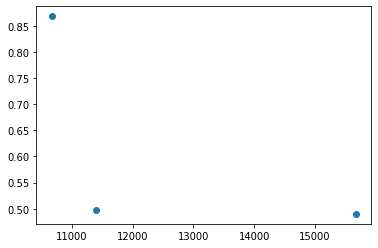

In [11]:
plt.scatter(euclidean, acc)

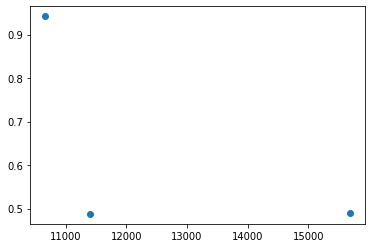

In [12]:
fig, ax = plt.subplots()
ax.scatter(euclidean, auc, label="euclidean-auc")

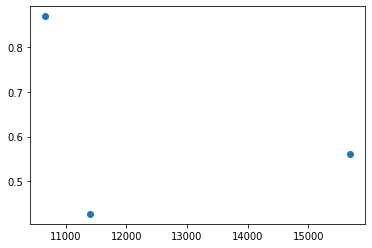

In [13]:
fig, ax = plt.subplots()
ax.scatter(euclidean, f1, label="euclidean-f1")

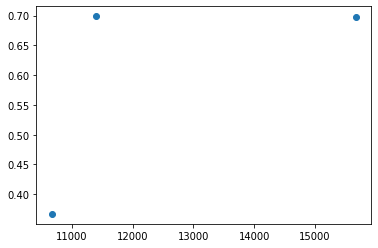

In [14]:
fig, ax = plt.subplots()
ax.scatter(euclidean, val_loss, label="euclidean-val_loss")